<a href="https://colab.research.google.com/github/derekschirripa/AERO_489_Machine_Learning/blob/main/AERO_489_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

Step 1: Create The trajectories modelled as Neural Networks using the sigmoid function

In [2]:
# Design the neural network
def createTraj():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))
    fhat.add(Dense(1))
    return fhat

x = createTraj()
y = createTraj()
thrust = createTraj()
moment = createTraj()
th = createTraj()

xdot = createTraj()
ydot = createTraj()
thdot = createTraj()

Step 2: Create the Loss Function

In [3]:
T0 = 0
Tf = 1
nPts = 20
T = tf.cast(tf.linspace(0,Tf,nPts),dtype=tf.float32)
pi = tf.constant(np.pi)

def errors(t,X0,Xf,obstacles):

  # Define obstacles as a list of tuples (x_center, y_center, radius)
    # obstacles = [(x1, y1, r1), (x2, y2, r2), ...]
    # loss function also takes in the initial and final conditions where X = [x,y,th,xdot,ydot,thdot]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        X = x(t)
        Y = y(t)
        TH = th(t)
        Xdot = xdot(t)
        Ydot = ydot(t)
        THdot = thdot(t)

    Xddot = tape.gradient(Xdot,t)
    Yddot = tape.gradient(Ydot,t)
    THddot = tape.gradient(THdot,t)

    M  = moment(t)
    Thrust = thrust(t)

    # Error in dynamics
    e_xddot = tf.reduce_sum((tf.reshape(Xddot,shape=(nPts,1)) - Thrust*tf.cos(TH))**2)
    e_yddot = tf.reduce_sum((tf.reshape(Yddot,shape=(nPts,1)) - Thrust*tf.sin(TH))**2)
    e_thddot = tf.reduce_sum((tf.reshape(THddot,shape=(nPts,1)) - M)**2)

    # Error in initial condition

    eIC = (X[0] - X0[0])**2  + (Y[0] - X0[1])**2  + (TH[0] - X0[2])**2 + (Xdot[0] - X0[3])**2 + (Ydot[0] - X0[4])**2 + (THdot[0] - X0[5])**2 + Thrust[0]**2 + M[0]**2

    # Error in final condition

    eFC = (X[-1] - Xf[0])**2 + (Y[-1] - Xf[1])**2 + (TH[-1]-Xf[2])**2 + (Xdot[-1] - Xf[3])**2 + (Ydot[-1] - Xf[4])**2 + (THdot[-1] - Xf[5])**2 + Thrust[-1]**2 + M[-1]**2

    # Calculate distance between each trajectory point and the center of each obstacle
    obstacle_penalties = []
    for obstacle in obstacles:
        x_obstacle, y_obstacle, radius = obstacle
        distance_to_obstacle = tf.sqrt((X - x_obstacle)**2 + (Y - y_obstacle)**2)
        obstacle_penalties.append(tf.reduce_sum(tf.maximum(0, radius - distance_to_obstacle)**2))

    # Error in obstacle avoidance
    e_obstacle_avoidance = tf.reduce_sum(obstacle_penalties)

    # Constraint errors for thrust and moment
    thrust_constraint_error = tf.reduce_sum(tf.maximum(0.0, -Thrust)) + tf.reduce_sum(tf.maximum(0.0, Thrust - 1.0))
    moment_constraint_error = tf.reduce_sum(tf.maximum(0.0, -M + 1.0)) + tf.reduce_sum(tf.maximum(0.0, M + 1.0))

    # Combine error components with weights
    total_error = 100 * e_xddot + 100 * e_yddot + 100 * e_thddot + eIC +  eFC + 1000 * e_obstacle_avoidance + 100 * thrust_constraint_error + 100 * moment_constraint_error
    # the error in obstacle avoidance is the highest weighed because it is paramount to the mission that we don't hit any obstacles
    return total_error


Step 3: Train the Network

In [11]:
X0 = [0,0,0,1,0,0]
Xf = [5,5,pi/2,0,1,0]
obstacles = [(2.5,2.5,2)]


nIter = 1001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

for i in range(nIter):
    with tf.GradientTape(persistent=True) as tape:
        e = errors(T,X0,Xf,obstacles)

    if i % 50 == 0:
        print(f'iter: {i}, error: {e}')

    # Compute gradients for all trainable variables
    grads = tape.gradient(e, x.trainable_variables + y.trainable_variables +
                          th.trainable_variables + xdot.trainable_variables +
                          ydot.trainable_variables + thdot.trainable_variables +
                          thrust.trainable_variables + moment.trainable_variables)

    # Apply gradients to all trainable variables
    optimizer.apply_gradients(zip(grads, x.trainable_variables + y.trainable_variables +
                                   th.trainable_variables + xdot.trainable_variables +
                                   ydot.trainable_variables + thdot.trainable_variables +
                                   thrust.trainable_variables + moment.trainable_variables))


    # Delete the tape to release the computational graph
    del tape

iter: 0, error: [4000.9993]
iter: 50, error: [4003.2397]
iter: 100, error: [4001.1143]
iter: 150, error: [4001.0469]
iter: 200, error: [4001.0315]
iter: 250, error: [4001.022]
iter: 300, error: [4001.0156]
iter: 350, error: [4001.011]
iter: 400, error: [4001.0076]
iter: 450, error: [4001.0054]
iter: 500, error: [4001.0037]
iter: 550, error: [4001.0024]
iter: 600, error: [4001.0015]
iter: 650, error: [4001.001]
iter: 700, error: [4001.0002]
iter: 750, error: [4001.]
iter: 800, error: [4000.9995]
iter: 850, error: [4000.9993]
iter: 900, error: [4000.999]
iter: 950, error: [4000.9988]
iter: 1000, error: [4000.9988]


Step 4: Plot the Results

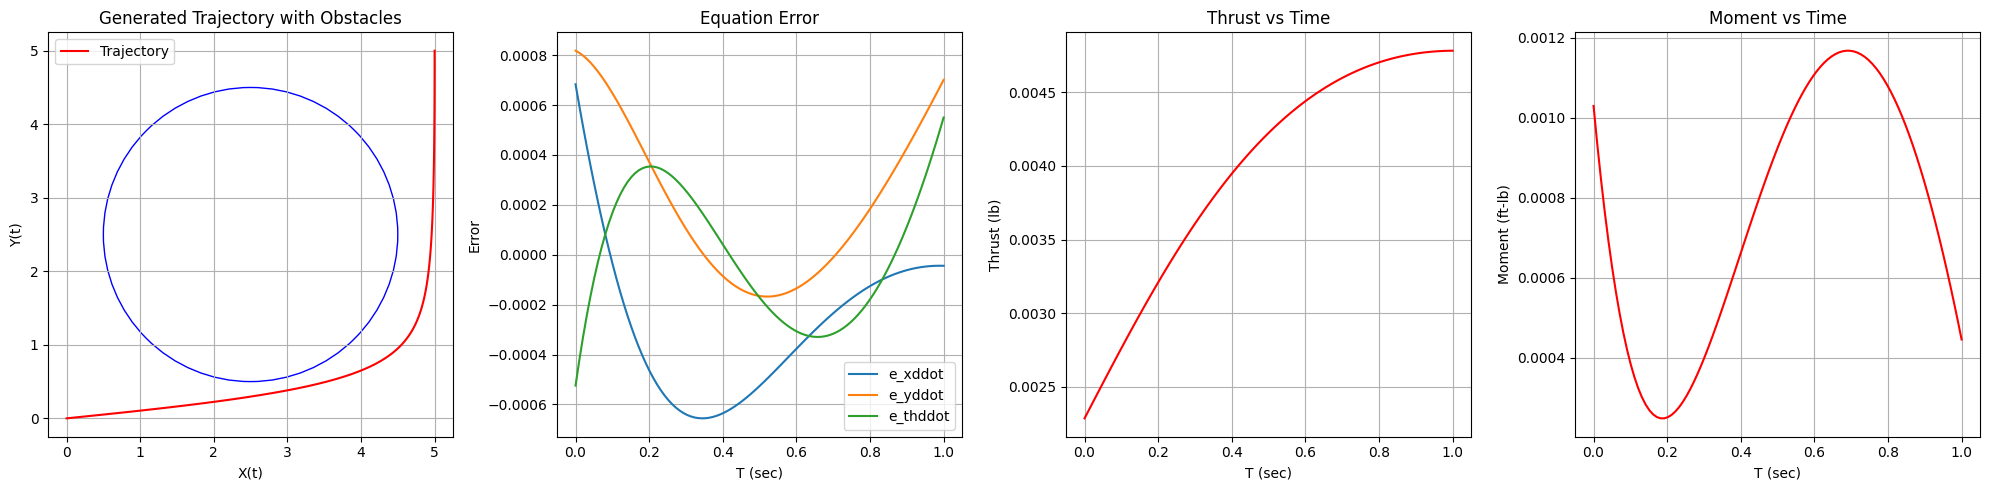

In [12]:
import matplotlib.pyplot as plt

# Define obstacle parameters (x_center, y_center, radius)
obstacles = [(2.5,2.5,2)]

# Generate trajectory
nPts1 = 100
TT = tf.cast(tf.linspace(0, Tf, nPts1), dtype=tf.float32)
tt = TT.numpy()

with tf.GradientTape(persistent=True) as tape:
    tape.watch(TT)
    X = x(TT)
    Y = y(TT)
    TH = th(TT)
    Xdot = xdot(TT)
    Ydot = ydot(TT)
    THdot = thdot(TT)

Xddot = tape.gradient(Xdot, TT)
Yddot = tape.gradient(Ydot, TT)
THddot = tape.gradient(THdot, TT)
M = moment(TT)
Thrust = thrust(TT)

e_xddot = tf.reshape(Xddot, shape=(nPts1, 1)) - Thrust * tf.cos(th(TT))
e_yddot = tf.reshape(Yddot, shape=(nPts1, 1)) - Thrust * tf.sin(th(TT))
e_thddot = tf.reshape(THddot, shape=(nPts1, 1)) - M

# Plot trajectory and obstacles
plt.figure(figsize=(20, 5))

# Plot trajectory and obstacles
plt.subplot(1, 4, 1)
plt.plot(X.numpy(), Y.numpy(), 'r', label='Trajectory')
for obstacle in obstacles:
    x_center, y_center, radius = obstacle
    circle = plt.Circle((x_center, y_center), radius, color='blue', fill=False)
    plt.gca().add_patch(circle)
plt.grid(True)
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory with Obstacles')
plt.legend()

# Plot equation error with error in theta_ddot
plt.subplot(1, 4, 2)
plt.plot(tt, e_xddot, label='e_xddot')
plt.plot(tt, e_yddot, label='e_yddot')
plt.plot(tt, e_thddot, label='e_thddot')
plt.grid(True)
plt.title('Equation Error')
plt.xlabel('T (sec)')
plt.ylabel('Error')
plt.legend()

# Plot thrust and moment vs time
plt.subplot(1, 4, 3)
plt.plot(tt, Thrust.numpy(), color = 'r')
plt.grid(True)
plt.title('Thrust vs Time')
plt.xlabel('T (sec)')
plt.ylabel('Thrust (lb)')


plt.subplot(1,4,4)
plt.plot(tt, M.numpy(), color = 'r')
plt.grid(True)
plt.title('Moment vs Time')
plt.xlabel('T (sec)')
plt.ylabel('Moment (ft-lb)')


plt.tight_layout()
plt.show()



The neural network has a fast learning rate. It takes about 2 minutes with 1000 iterations to have the network be taught to effectively dodge obstacles and obey the dynamics. The rate of optimization was increased by having the optimizer compute the gradients and apply them in two lines and then to delete the computational graph to decrease the memory consumption